# Everything is on the cloud now and I feel numb

There's something off about the distance calculation 

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [2]:
# the location of our credentials json and name of bigquery project
credentials = service_account.Credentials.from_service_account_file('C:\\Users\\elija\\Documents\\24f-coop\\credentials.json')
project = 'net-data-viz-handbook'

# Initialize a GCS client
client = bigquery.Client(credentials=credentials, project=project)

## Getting df_pivot for graphing porpoises

In [3]:
# df_pivot just because it's nice to have
query_pivot = """
SELECT *
FROM (
    SELECT 
        date,
        country_id,
        run_id,
        SUM(Infectious_13_17 + Infectious_18_23) AS total_infectious
    FROM `net-data-viz-handbook.sri_data.SIR_0_countries_incidence_daily`
    WHERE country_id IN (215)
      AND run_id BETWEEN 1 AND 100
    GROUP BY date, country_id, run_id
)
PIVOT (
    SUM(total_infectious) FOR run_id IN (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                                         21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
                                         41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 
                                         61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 
                                         81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100)
)
ORDER BY date;
"""

In [4]:
# Run the query
query_job = client.query(query_pivot)

# Fetch the results into a DataFrame
df_pivot = query_job.to_dataframe()

del df_pivot['country_id']
df_pivot.set_index('date', inplace=True)

df_pivot.columns = df_pivot.columns.str.replace('_', '', regex=False).astype(int)

# Display the first few rows
df_pivot.head()

C:\Users\elija\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
date,,,,,,,,,,,,,,,,,,,,,
2009-02-17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## KMeans and a prayer

### This one just uses the first num_features columns to simplify the KMeans algorithms, which is O(n<sup>2</sup>)

In [14]:
# Set parameters for the K-means model
num_clusters = 3  # Example number of clusters
num_features = 5   # Set the number of features to select

# Step 1: Create the MSE matrix table
query_mse_matrix = """
CREATE OR REPLACE TABLE sri_data.mse_matrix AS
WITH infectious_data AS (
    SELECT
        date,
        country_id,
        run_id,
        SUM(Infectious_13_17 + Infectious_18_23) AS total_infectious
    FROM
        net-data-viz-handbook.sri_data.SIR_0_countries_incidence_daily
    WHERE
        country_id IN (215) AND run_id BETWEEN 1 AND 100
    GROUP BY
        date,
        country_id,
        run_id
)
SELECT
    a.run_id AS run_id_a,
    b.run_id AS run_id_b,
    AVG(POW(a.total_infectious - b.total_infectious, 2)) AS mse
FROM
    infectious_data a
JOIN
    infectious_data b
ON
    a.date = b.date
GROUP BY
    run_id_a, run_id_b
"""
client.query(query_mse_matrix).result()  # Execute the query to create the table
print("MSE matrix table created successfully.")

# Step 2: Create the ABC matrix table
query_abc_matrix = """
CREATE OR REPLACE TABLE sri_data.abc_matrix AS
WITH infectious_data AS (
    SELECT
        date,
        country_id,
        run_id,
        SUM(Infectious_13_17 + Infectious_18_23) AS total_infectious
    FROM
        net-data-viz-handbook.sri_data.SIR_0_countries_incidence_daily
    WHERE
        country_id IN (215) AND run_id BETWEEN 1 AND 100
    GROUP BY
        date,
        country_id,
        run_id
)
SELECT
    a.run_id AS run_id_a,
    b.run_id AS run_id_b,
    SUM(ABS(a.total_infectious - b.total_infectious)) AS abc
FROM
    infectious_data a
JOIN
    infectious_data b
ON
    a.date = b.date
GROUP BY
    run_id_a, run_id_b
"""
client.query(query_abc_matrix).result()  # Execute the query to create the table
print("ABC matrix table created successfully.")

# Step 3: Create the distance matrix
query_distance_matrix = """
CREATE OR REPLACE TABLE sri_data.distance_matrix AS
SELECT
    run_id_a AS run_id,
    ARRAY_AGG(STRUCT(run_id_b, mse) ORDER BY run_id_b ASC) AS distances
FROM
    sri_data.mse_matrix
GROUP BY
    run_id_a;
"""
client.query(query_distance_matrix).result()  # Execute the query to create the table
print("Distance matrix table created successfully.")

# Step 4: Create the K-means model by selecting the first num_features features based on actual distances
query_create_model = f"""
CREATE OR REPLACE MODEL sri_data.kmeans_model
OPTIONS(model_type='kmeans', num_clusters={num_clusters}) AS
SELECT
    run_id,
    ARRAY(
        SELECT distance.mse 
        FROM UNNEST(distances) AS distance 
        WHERE distance.run_id_b <= {num_features}  -- Select only the first num_features
    ) AS features
FROM
    sri_data.distance_matrix;
"""
client.query(query_create_model).result()  # Execute the model creation
print("K-means model created successfully.")

# Step 5: Apply K-means clustering using the model
query_kmeans = f"""
SELECT
    *
FROM
    ML.PREDICT(MODEL sri_data.kmeans_model,
        (SELECT
            run_id,
            ARRAY(
                SELECT distance.mse 
                FROM UNNEST(distances) AS distance 
                WHERE distance.run_id_b <= {num_features}  -- Select only the first num_features
            ) AS features
         FROM
            sri_data.distance_matrix)
    ) AS predictions;
"""
kmeans_result = client.query(query_kmeans).to_dataframe()  # Execute and fetch results
print("K-means clustering applied successfully.")

MSE matrix table created successfully.
ABC matrix table created successfully.
Distance matrix table created successfully.
K-means model created successfully.


C:\Users\elija\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


K-means clustering applied successfully.


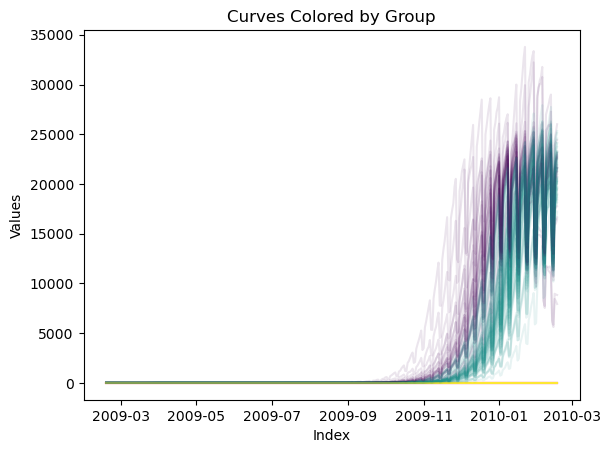

In [16]:
groups = kmeans_result.sort_values('run_id')['CENTROID_ID'].values

unique_groups = np.unique(groups)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_groups)))  # Color map
group_colors = {group: color for group, color in zip(unique_groups, colors)}

for col in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[col].rolling(1).median(), label=f'Column {col}', color=group_colors[groups[col - 1]], alpha=.1)

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Curves Colored by Group')
plt.show()


In [24]:
kmeans_result

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,run_id,features
0,2,"[{'CENTROID_ID': 2, 'DISTANCE': 46480638.40152...",72,"[8553223.898907105, 11093786.469945356, 176836..."
1,3,"[{'CENTROID_ID': 3, 'DISTANCE': nan}, {'CENTRO...",38,"[32294617.013661202, 0.0, 45001932.704918034, ..."
2,1,"[{'CENTROID_ID': 1, 'DISTANCE': 13374671.11071...",4,"[12157044.86612022, 59281915.63387978, 5105668..."
3,3,"[{'CENTROID_ID': 3, 'DISTANCE': nan}, {'CENTRO...",20,"[32294617.013661202, 0.0, 45001932.70491804, 5..."
4,2,"[{'CENTROID_ID': 2, 'DISTANCE': 2959785.773980...",78,"[414097.3087431694, 39606542.40983607, 1127026..."
...,...,...,...,...
95,3,"[{'CENTROID_ID': 3, 'DISTANCE': 0.607364019082...",99,"[32294617.0136612, 0.0, 45001932.704918034, 59..."
96,3,"[{'CENTROID_ID': 3, 'DISTANCE': nan}, {'CENTRO...",15,"[32294617.013661206, 0.0, 45001932.704918034, ..."
97,1,"[{'CENTROID_ID': 1, 'DISTANCE': 13490458.11425...",19,"[8662060.281420765, 71647592.18579236, 3405109..."
98,2,"[{'CENTROID_ID': 2, 'DISTANCE': 27384935.99672...",93,"[2794472.762295082, 20814419.081967216, 936471..."


In [28]:
# Step 5: Apply K-means clustering and save results in a table
query_kmeans = f"""
CREATE OR REPLACE TABLE sri_data.kmeans_results AS
SELECT
    *
FROM
    ML.PREDICT(MODEL sri_data.kmeans_model,
        (SELECT
            run_id,
            ARRAY(
                SELECT distance.mse 
                FROM UNNEST(distances) AS distance 
                WHERE distance.run_id_b <= {num_features}  
            ) AS features
         FROM
            sri_data.distance_matrix)
    ) AS predictions
"""
client.query(query_kmeans).result()  # Execute the model creation
print("K-means clustering results saved successfully.")


K-means clustering results saved successfully.


In [64]:
# Step 6: Sum distances within each cluster
query_sum_distances = """
WITH clustered_curves AS (
    SELECT 
        kr.run_id AS run_id,
        kr.CENTROID_ID,
        dm_dist.mse
    FROM 
        `sri_data.kmeans_results` AS kr
    JOIN 
        `sri_data.distance_matrix` AS dm
    ON 
        kr.run_id = dm.run_id
    CROSS JOIN 
        UNNEST(dm.distances) AS dm_dist  -- Unnest the distances array here
)
SELECT 
    run_id,
    CENTROID_ID,
    SUM(mse) AS total_distance
FROM 
    clustered_curves
GROUP BY 
    run_id, CENTROID_ID
ORDER BY 
    CENTROID_ID, run_id;
"""
total_distances = client.query(query_sum_distances).to_dataframe()  # Execute and fetch results
print("Total distances summed within each cluster successfully.")


Total distances summed within each cluster successfully.


C:\Users\elija\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



In [91]:
# Step 6: Sum distances within each cluster
percentile = .5

query_sum_distances = f"""
WITH clustered_curves AS (
    SELECT 
        kr.run_id AS run_id,
        kr.CENTROID_ID,
        dm_dist.mse
    FROM 
        `sri_data.kmeans_results` AS kr
    JOIN 
        `sri_data.distance_matrix` AS dm
    ON 
        kr.run_id = dm.run_id
    CROSS JOIN 
        UNNEST(dm.distances) AS dm_dist  -- Unnest the distances array here
),
total_distances AS (
    SELECT 
        run_id,
        CENTROID_ID,
        SUM(mse) AS total_distance
    FROM 
        clustered_curves
    GROUP BY 
        run_id, CENTROID_ID
),
ranked_distances AS (
    SELECT 
        run_id,
        CENTROID_ID,
        total_distance,
        ROW_NUMBER() OVER (PARTITION BY CENTROID_ID ORDER BY total_distance ASC) AS rank,
        COUNT(*) OVER (PARTITION BY CENTROID_ID) AS total_count
    FROM 
        total_distances
)
SELECT 
    run_id,
    CENTROID_ID,
    total_distance
FROM 
    ranked_distances
WHERE 
    rank <= total_count * {percentile}
ORDER BY 
    CENTROID_ID, run_id;

"""
total_distances = client.query(query_sum_distances).to_dataframe()  # Execute and fetch results
print("Total distances summed within each cluster successfully.")


C:\Users\elija\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



Total distances summed within each cluster successfully.


In [92]:
total_distances[total_distances['CENTROID_ID'] == 1].sort_values('total_distance', ascending=False)

,run_id,CENTROID_ID,total_distance
9,84,1,2.227393e+09
3,36,1,2.101907e+09
6,52,1,2.079730e+09
5,49,1,2.073209e+09
1,5,1,1.997348e+09
10,92,1,1.947995e+09
0,4,1,1.924702e+09
7,59,1,1.841590e+09
2,29,1,1.800601e+09
8,60,1,1.778660e+09


In [93]:
import plotly.graph_objects as go
import pandas as pd

# Create a figure
fig = go.Figure()

# Define a list of colors for distinct centroids
colors = [
    'rgba(255, 0, 0, {alpha})',    # Red
    'rgba(0, 255, 0, {alpha})',    # Green
    'rgba(0, 0, 255, {alpha})',    # Blue
    'rgba(255, 255, 0, {alpha})',  # Yellow
    'rgba(255, 0, 255, {alpha})',  # Magenta
    'rgba(0, 255, 255, {alpha})',  # Cyan
    'rgba(128, 0, 128, {alpha})',  # Purple
    # Add more colors as needed
]

# Loop through each run_id to plot the curves
for index, row in total_distances.iterrows():
    run_id = row['run_id']
    centroid_id = row['CENTROID_ID']
    total_distance = row['total_distance']

    # Get the curve data for the run_id from df_pivot
    curve_data = df_pivot[run_id].rolling(7).median()

    # Calculate alpha value based on total distance
    alpha_value = max(0.1, 1 - (total_distance / total_distances['total_distance'].max()))/10  # Ensure alpha is between 0 and 1

    # Select a color for the centroid
    color = colors[centroid_id % len(colors)].format(alpha=alpha_value)  # Loop through colors based on centroid_id

    # Add the curve to the figure
    fig.add_trace(go.Scatter(
        x=curve_data.index,  # Assuming the x-axis is the index of df_pivot
        y=curve_data.values,  # y-values from df_pivot
        mode='lines',
        name=f'Run ID {run_id}',
        line=dict(color=color),  # Use the selected color
        showlegend=False
    ))

# Update layout
fig.update_layout(
    title='Curves by Centroid ID with Distance-based Alpha',
    xaxis_title='Date',  # Change this to your desired x-axis label
    yaxis_title='Incidence',  # Change this to your desired y-axis label
    legend_title='Run ID',
)

# Show the figure
fig.show()
